In [67]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from statsmodels.stats.outliers_influence import variance_inflation_factor
import lightgbm as lgb
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Win/Loss Classification
Using the final dataframe collected and aggregated from FiveThirtyEight, baseball-reference.com, Retrosheet.org, and the NOAA Weather Service, (see data collection/exploration in this repo and in mlb_spread_betting repo) the end goal is to accurately model the spread. The first step in this process will be predicting the game winner, and then using this prediction as a feature to predict the spread. 

In [3]:
#read in full data set
full_ = pd.read_csv('all_features.csv.gz', compression = 'gzip')
#drop merge keys and non-numeric columns
full_ = full_.drop(columns = ['date', 'team1', 'team2', 'home_starter', 'road_starter',
                             'is_doubleheader', 'is_tripleheader', 'score1', 'score2'])
X, y = full_.drop(columns = ['home_loss']), full_['home_loss']

# Outlier Detection / Removal

Before beginning feature selection and modeling, it is always prudent to search for outliers and potential problem data among features. I have already done this for the data from the Elo dataset (see __EDA.ipynb__ in the mlb_spread_betting repo __TO DO: MERGE THESE TWO REPOS__). I designed the script that parsed the Retrosheet play by play files with checks to ensure data accuracy, but there were several levels of data conversion and calculations so it's possible that some mistakes may have slipped through. Also, the way statistics were collected and calculated was to account for pitchers and teams changing from season to season. Thus, some features represent career statistics, and others represent season statistics. Due to the nature of season statistics, each pitcher/team starts from zero at the beginning of a given season. If a pitcher or team has a spectacularly good or spectacularly bad first game, it can lead to statistics hundreds of standard deviations from the mean. While these may not be inaccurate datapoints (I have looked in to several of these cases and confirmed them), it still will be counterproductive for generating a model and thus will likely be removed anyway.

My methodology will be simple: View the distribution of data with box plots, generate tolerance level for each statistic based on the box plot, and generate a list of indices of observations that exceed these tolerances. Then, I will run an IsolationForest on the feature frame and determine the overlap between anomalies detected by isolation forest and anomalies detected by my investigation

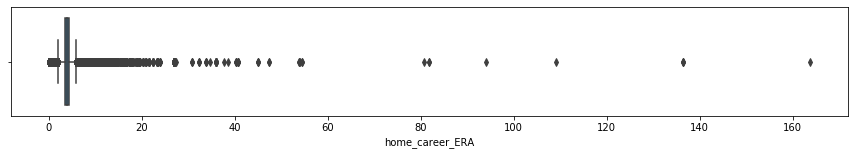

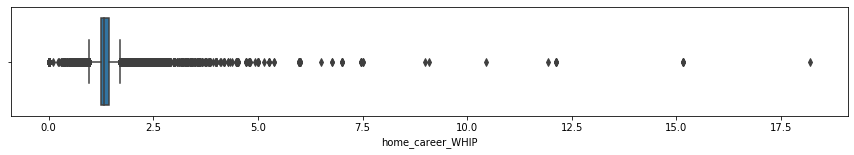

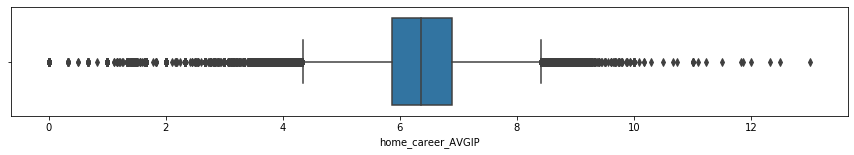

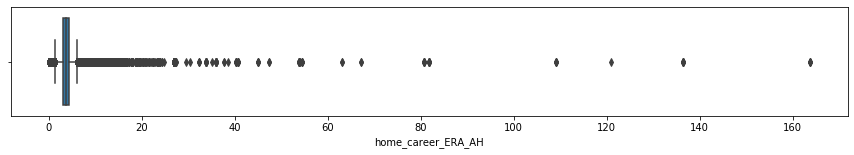

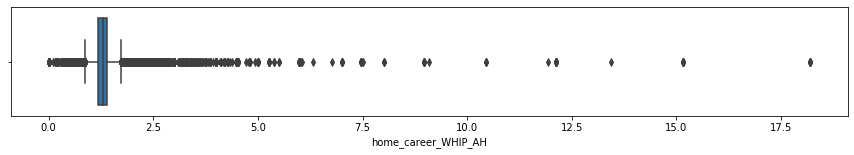

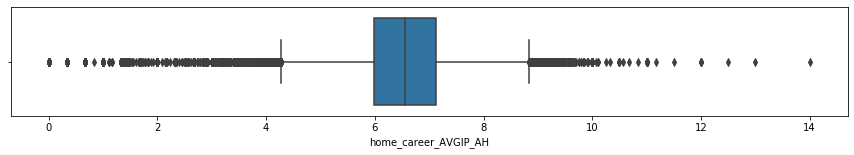

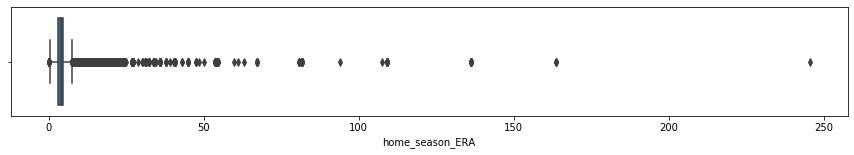

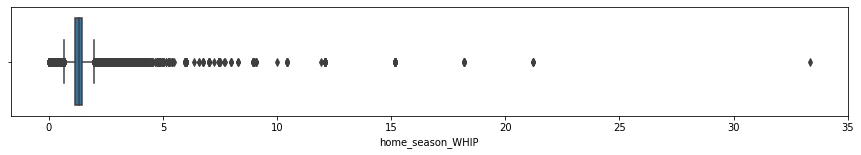

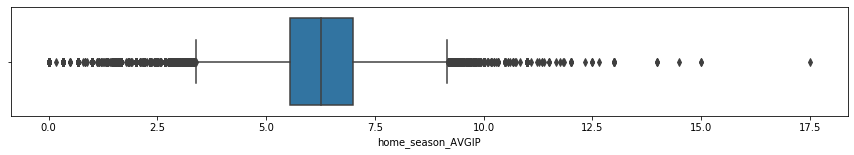

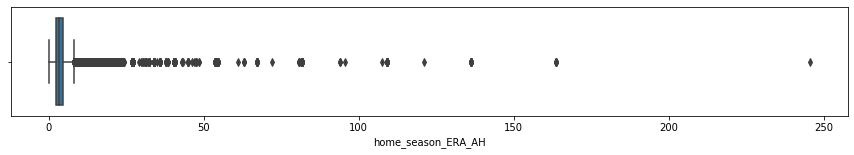

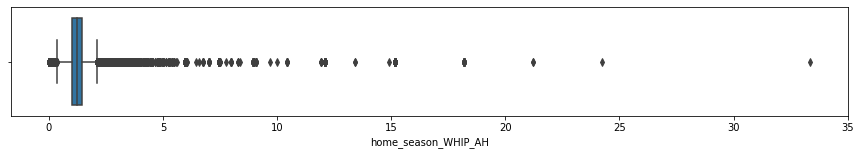

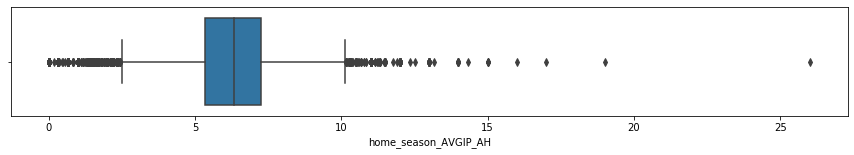

In [4]:
#view distribution for home starting pitcher statistics, check for outliers
starter_features = ['home_career_ERA', 'home_career_WHIP', 'home_career_AVGIP', 'home_career_ERA_AH',
                   'home_career_WHIP_AH', 'home_career_AVGIP_AH', 'home_season_ERA', 'home_season_WHIP',
                   'home_season_AVGIP', 'home_season_ERA_AH', 'home_season_WHIP_AH', 'home_season_AVGIP_AH']
for feature in starter_features:
    plt.figure(figsize = (15,2))
    sns.boxplot(x = X[feature])

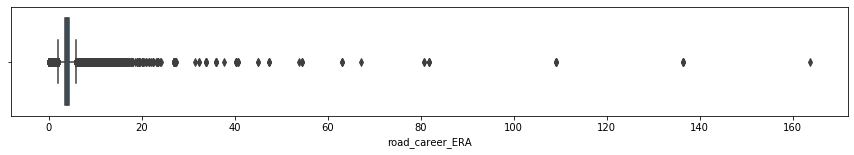

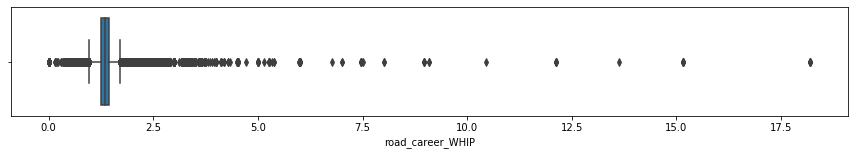

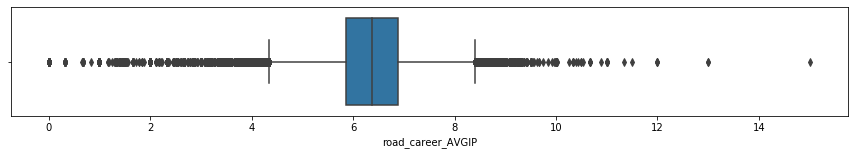

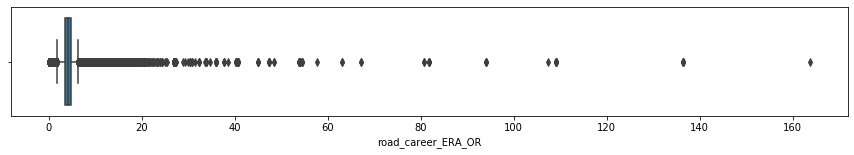

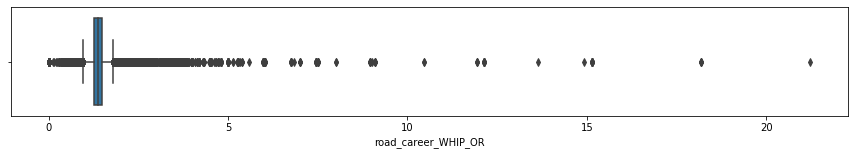

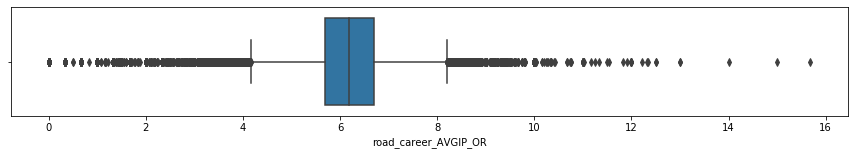

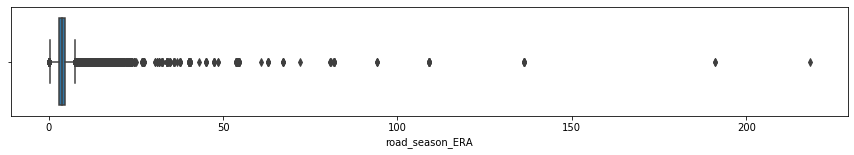

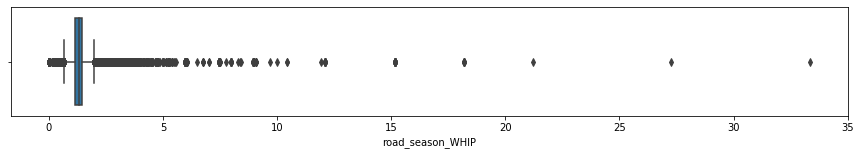

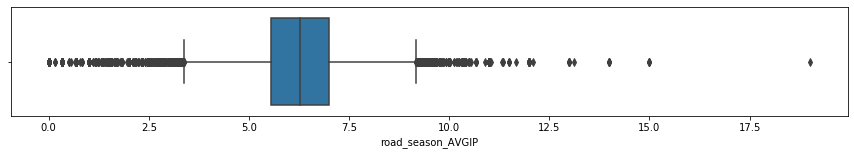

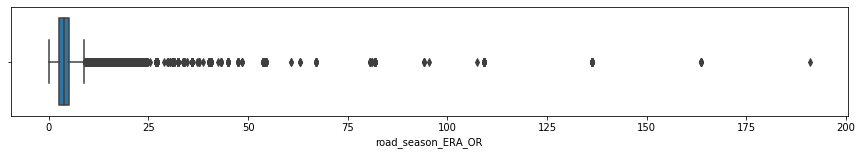

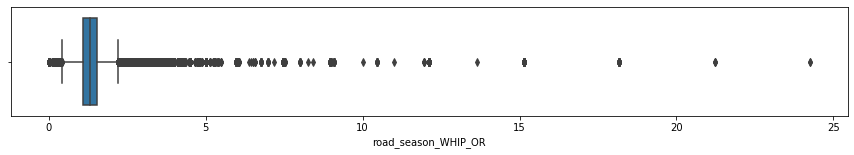

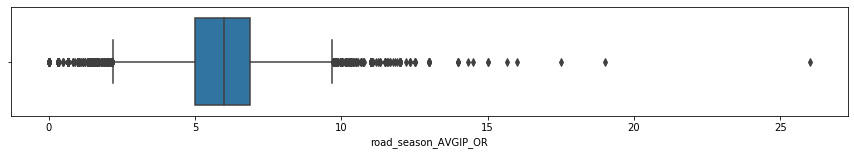

In [5]:
#repeat process with road pitchers
starter_features = ['road_career_ERA', 'road_career_WHIP', 'road_career_AVGIP', 'road_career_ERA_OR',
                   'road_career_WHIP_OR', 'road_career_AVGIP_OR', 'road_season_ERA', 'road_season_WHIP',
                   'road_season_AVGIP', 'road_season_ERA_OR', 'road_season_WHIP_OR', 'road_season_AVGIP_OR']
for feature in starter_features:
    plt.figure(figsize = (15,2))
    sns.boxplot(x = X[feature])

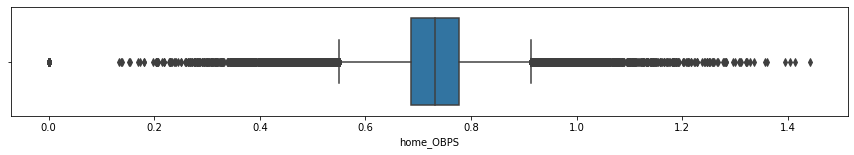

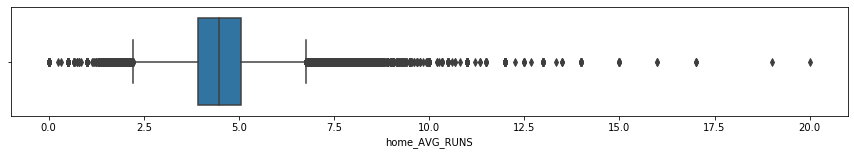

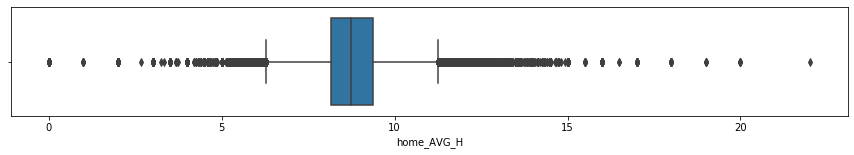

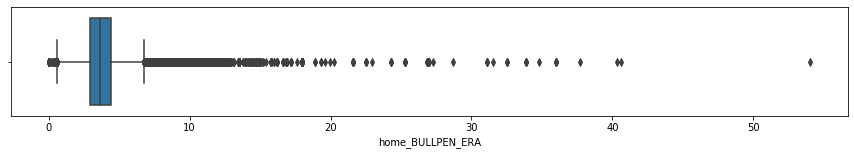

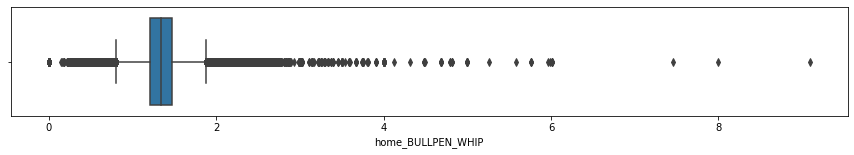

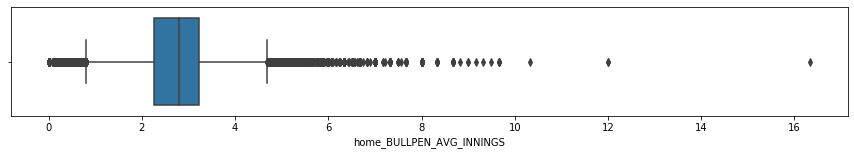

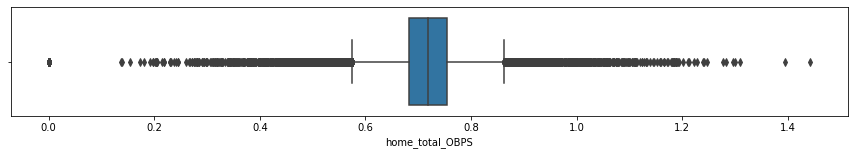

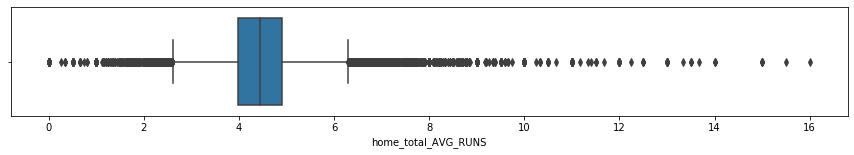

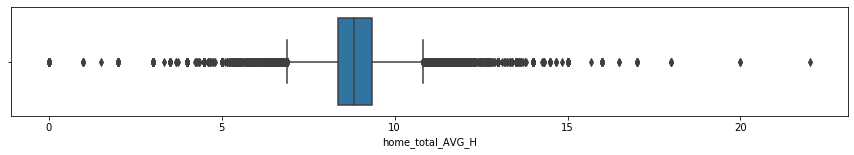

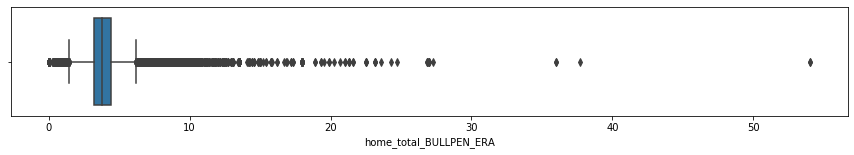

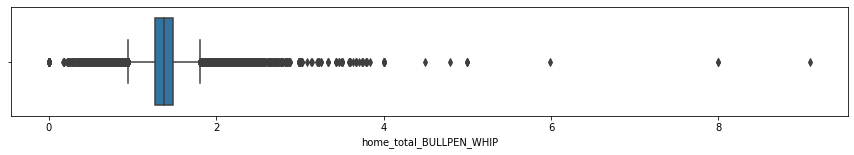

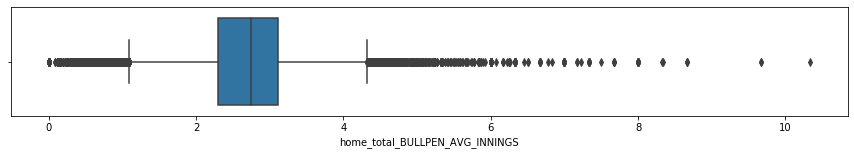

In [6]:
#look through home and road team features now
home_team_features = ['home_OBPS', 'home_AVG_RUNS', 'home_AVG_H', 'home_BULLPEN_ERA', 'home_BULLPEN_WHIP', 
                   'home_BULLPEN_AVG_INNINGS','home_total_OBPS', 'home_total_AVG_RUNS', 'home_total_AVG_H', 
                   'home_total_BULLPEN_ERA', 'home_total_BULLPEN_WHIP','home_total_BULLPEN_AVG_INNINGS']
for feature in home_team_features:
    plt.figure(figsize = (15,2))
    sns.boxplot(x = X[feature])

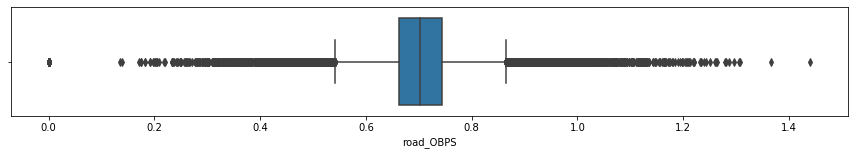

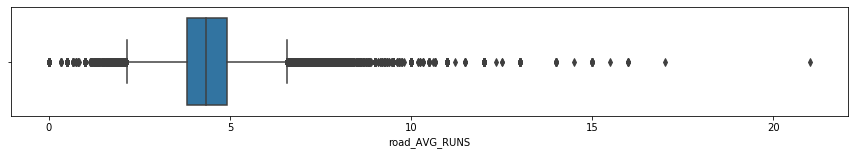

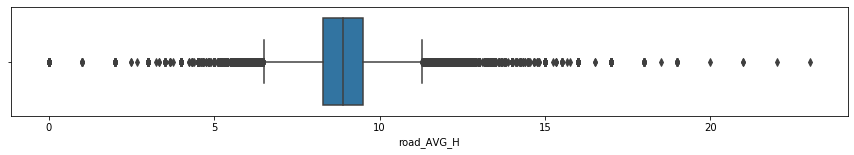

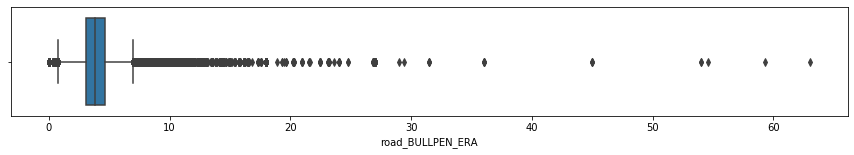

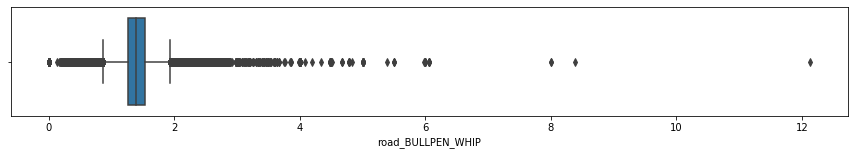

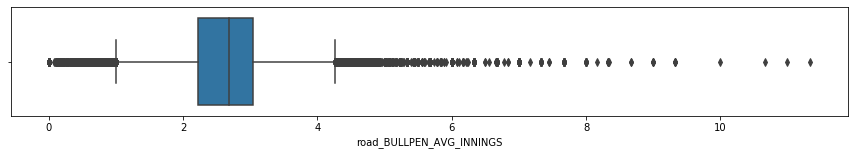

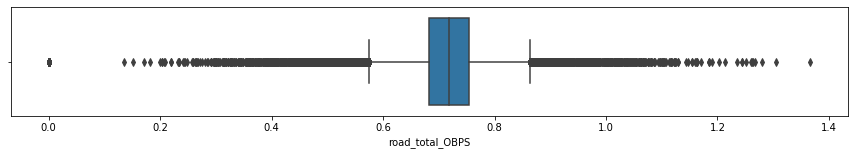

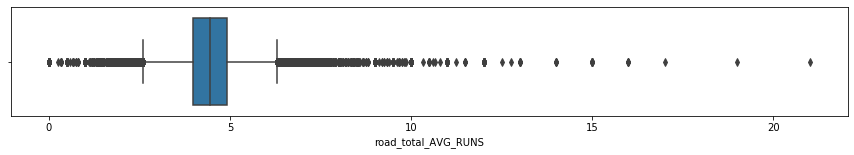

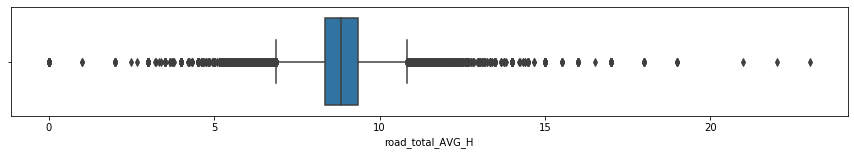

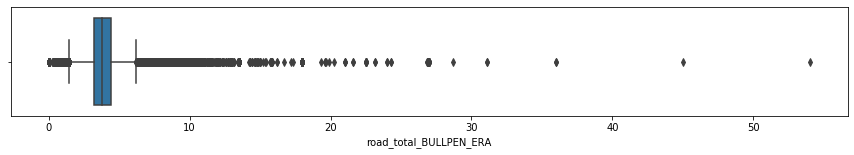

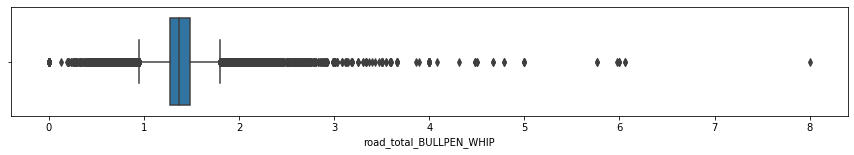

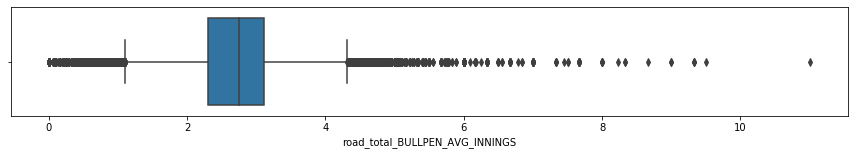

In [7]:
#road team features
road_team_features = ['road_OBPS', 'road_AVG_RUNS', 'road_AVG_H', 'road_BULLPEN_ERA', 'road_BULLPEN_WHIP', 
                   'road_BULLPEN_AVG_INNINGS','road_total_OBPS', 'road_total_AVG_RUNS', 'road_total_AVG_H', 
                   'road_total_BULLPEN_ERA', 'road_total_BULLPEN_WHIP','road_total_BULLPEN_AVG_INNINGS']
for feature in road_team_features:
    plt.figure(figsize = (15,2))
    sns.boxplot(x = X[feature])

In [4]:
#generate empty list to store potential outliers 
removal_indices = []
tol_dict = {'home_career_ERA' : 30,
           'home_career_WHIP' : 5,
           'home_career_ERA_AH' : 30,
           'home_career_WHIP_AH' : 5,
           'home_season_ERA' : 30,
           'home_season_WHIP' : 5,
           'home_season_ERA_AH' : 30,
           'home_season_WHIP_AH' : 5,
           'road_career_ERA' : 30,
           'road_career_WHIP' : 5,
           'road_career_ERA_OR' : 30,
           'road_career_WHIP_OR' : 5,
           'road_season_ERA' : 30,
           'road_season_WHIP' : 5,
           'road_season_ERA_OR' : 30,
           'road_season_WHIP_OR' : 5,
           'home_BULLPEN_ERA' : 30,
           'home_BULLPEN_WHIP' : 5,
           'home_total_BULLPEN_ERA' : 30,
           'home_total_BULLPEN_WHIP' : 5,
           'road_BULLPEN_ERA' : 30,
           'road_BULLPEN_WHIP' : 5,
           'road_total_BULLPEN_ERA' : 30,
           'road_total_BULLPEN_WHIP' : 5,}
#iterate through frame and generate list of indices of potential outliers
for key in tol_dict.keys():
    indices = list(X[X[key] > tol_dict[key]].index)
    for index in indices:
        if index not in removal_indices:
            removal_indices.append(index)

In [5]:
#generate set of retrosheet features to run through isolation forest
all_features = pd.Series(X.columns)
retro_features = all_features[(all_features.str.contains('home')) | (all_features.str.contains('road'))]
#drop one feature from elo set with 'home' in feature name
retro_features = retro_features.drop(69, axis = 0)

In [6]:
#use length of removal indices as contamination tolerance
con_tol = len(removal_indices) / len(X)
#generate subset of X using only Retrosheet features
retro_X = X[retro_features]
#fit isolation forest on set and predict outliers
iso = IsolationForest(n_estimators = 100, contamination = con_tol, behaviour = 'new', random_state = 43)
projected_outliers = iso.fit_predict(retro_X)

In [7]:
#generate pandas series of outlier predictions
outlier_series = pd.Series(projected_outliers)
#concatenate with main frame, rename column is_outlier
with_outliers = pd.concat([retro_X, outlier_series], axis = 1).rename(columns = {0 : 'is_outlier'})
#generate list of indices of potential outliers to compare with removal_indices
outlier_indices = with_outliers[with_outliers.is_outlier == -1].index

In [8]:
#iterate through indices, checking to see if there is any overlap between indices
ticker = 0 
for j in outlier_indices:
    if j in removal_indices:
        ticker += 1
print(ticker)

13


Visual investigation and isolation forest only returned 13 of the same observations. Therefore, I will experiment with removing outiers based on each individual method, both methods, or neither.

In [5]:
#create dataframes with outliers removed
X = X.drop(removal_indices, axis = 0)
y = y.drop(removal_indices, axis = 0)

# BASELINE TESTING

In [10]:
#split into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
#train and test baseline logistic regression model
lr = LogisticRegression(solver = 'lbfgs', max_iter = 1000)
lr.fit(x_train, y_train)
lr_preds = lr.predict(x_test)
lr_accuracy = accuracy_score(y_test, lr_preds)
#train and test baseline SGD Classifier
sgd = SGDClassifier()
sgd.fit(x_train, y_train)
sgd_preds = sgd.predict(x_test)
sgd_accuracy = accuracy_score(y_test, sgd_preds)
print('Baseline logistic regression accuracy: {}'.format(lr_accuracy))
print()
print('Baseline SGD Classifier accuracy {}'.format(sgd_accuracy))

Baseline logistic regression accuracy: 0.5749940856399337

Baseline SGD Classifier accuracy 0.5406513681886287


# FEATURE SELECTION- TREE BASED MODELS

To determine the final feature set to use in parameter tuning and model building, I have developed a __FeatureSelector__ object (see __recursive_selection.py__ for a full explanation of this object) to perform recursive features selection. While FeatureSelector offers several different methods of feature selection, with tree-based models I will use the feature importances attribute and iterate through the full feature frame, removing the least important features at each iteration and evaluating the new feature set using 5 fold cross validation with a given metric (in this case, with two balanced classes, it will be accuracy). I will perform this in several different cases: with the full feature frame, reduced feature frame after removing highly correlated features, and the feature frame with features normalized to mean 0 and unit variance. NOTE: Unless otherwise specified with n_jobs parameter, FeatureSelector will run all available processors.

In [6]:
from recursive_selection import FeatureSelector

In [17]:
#generate dictionary of algorithms to select features based on feature importance and specify generic base
#parameters to be passed to FeatureSelector object
tree_based = {'RandomForestClassifier': (RandomForestClassifier(), {'n_estimators' : 50,
                                                                   'max_depth' : 5}),
             'LGBMClassifier' : (lgb.LGBMClassifier(), {'num_leaves' : 30,
                                                       'max_depth' : 3}),
             'XGBClassifier' : (xgb.XGBClassifier(), {'max_depth' : 5,
                                                     'n_estimators' : 50})}
#function to initialize results dictionary for each algorithm to be called to compare results
def initialize_results_dict():
    return( {'Algorithm' : None,
            'best_eval_full' : None,
            'best_subset_full' : None,
            'best_eval_drop_corr' : None,
            'best_subset_drop_corr' : None})
#empty list to store result dictionaries- can be easily made into dataframe using pd.concat
results_list = []

#iterate through algorithms, use recursive_selection method of FeatureSelector object, first using full feature set,
#then eliminating correlated features (with given tolerance)
for algo in tree_based:
    result = initialize_results_dict()
    result['Algorithm'] = algo
    selector = FeatureSelector(X, y, algorithm = tree_based[algo][0], params = tree_based[algo][1], drop_size = 10)
    selector.recursive_selection()
    result['best_eval_full'] = selector.best_eval
    result['best_subset_full'] = selector.best_subset
    print('Best evaluation was {} for {}, dropping correlated features and retrying'.format(selector.best_eval,
                                                                                           algo))
    selector = FeatureSelector(X, y, algorithm = tree_based[algo][0], drop_corr = True,
                               params = tree_based[algo][1], drop_size = 10, correlation_tolerance = 0.7)
    selector.recursive_selection()
    result['best_eval_drop_corr'] = selector.best_eval
    result['best_subset_drop_corr'] = selector.best_subset
    print('Best evaluation was {} for {} with correlated features removed, moving to next algorithm'\
         .format(selector.best_eval, algo))
    results_list.append(result)

Best evaluation was 0.5724035959309204 for RandomForestClassifier, dropping correlated features and retrying
Best evaluation was 0.572444996451384 for RandomForestClassifier with correlated features removed, moving to next algorithm
Best evaluation was 0.5747870830376154 for LGBMClassifier, dropping correlated features and retrying
Best evaluation was 0.574089188549799 for LGBMClassifier with correlated features removed, moving to next algorithm
Best evaluation was 0.57416607523066 for XGBClassifier, dropping correlated features and retrying
Best evaluation was 0.5736160397444996 for XGBClassifier with correlated features removed, moving to next algorithm


In [18]:
#create dataframe to evaluate results
results_df = pd.DataFrame(results_list)

In [19]:
#review dataframe 
results_df

,Algorithm,best_eval_full,best_subset_full,best_eval_drop_corr,best_subset_drop_corr
0,RandomForestClassifier,0.572404,"Index(['home_career_WHIP', 'home_career_AVGIP'...",0.572445,"Index(['home_OBPS', 'road_OBPS', 'home_career_..."
1,LGBMClassifier,0.574787,"Index(['home_OBPS', 'home_BULLPEN_WHIP', 'home...",0.574089,"Index(['home_OBPS', 'home_BULLPEN_ERA', 'home_..."
2,XGBClassifier,0.574166,"Index(['home_OBPS', 'home_AVG_RUNS', 'home_BUL...",0.573616,"Index(['home_OBPS', 'home_BULLPEN_ERA', 'home_..."


In [20]:
#save feature selector subsets frame 
results_df.to_csv('./intermediate_data/feature_selection_no_scale.csv', index = False)

As can be seen from this table, the highest performing algorithm was the LGBMClassifier, and the best subset is available. I will run the same method, but this time with a scaled feature frame to test if this improves performance. 

In [21]:
#new result list
results_list = []

#iterate through algorithms, use recursive_selection method of FeatureSelector object, first using full feature set,
#then eliminating correlated features (with given tolerance), this time with scaled features
for algo in tree_based:
    result = initialize_results_dict()
    result['Algorithm'] = algo
    selector = FeatureSelector(X, y, algorithm = tree_based[algo][0], scale = 'standard', 
                               params = tree_based[algo][1], drop_size = 10)
    selector.recursive_selection()
    result['best_eval_full'] = selector.best_eval
    result['best_subset_full'] = selector.best_subset
    selector = FeatureSelector(X, y, algorithm = tree_based[algo][0], scale = 'standard', drop_corr = True,
                               params = tree_based[algo][1], drop_size = 10, correlation_tolerance = 0.6)
    selector.recursive_selection()
    result['best_eval_drop_corr'] = selector.best_eval
    result['best_subset_drop_corr'] = selector.best_subset
    results_list.append(result)

In [22]:
#generate DataFrame of results for scaled data
scaled_results_df = pd.DataFrame(results_list)
scaled_results_df

,Algorithm,best_eval_full,best_subset_full,best_eval_drop_corr,best_subset_drop_corr
0,RandomForestClassifier,0.572433,"Index(['home_career_WHIP', 'home_career_AVGIP'...",0.572315,"Index(['home_OBPS', 'road_OBPS', 'home_career_..."
1,LGBMClassifier,0.574917,"Index(['home_OBPS', 'home_BULLPEN_WHIP', 'home...",0.574113,"Index(['home_OBPS', 'road_OBPS', 'home_season_..."
2,XGBClassifier,0.574296,"Index(['home_AVG_RUNS', 'home_total_OBPS', 'ho...",0.573131,"Index(['home_OBPS', 'home_BULLPEN_ERA', 'home_..."


In [23]:
#save feature selector frame
scaled_results_df.to_csv('./intermediate_data/feature_selection_scaled.csv', index = False)

LightGBM Classifier is again the best performer, with a slight improvement with scaled features. 

In [6]:
#read back in frames generated via FeatureSelector to continue analysis
results_df = pd.read_csv('./intermediate_data/feature_selection_no_scale.csv')
scaled_results_df = pd.read_csv('./intermediate_data/feature_selection_scaled.csv')

## Note: Wrote these feature indices to .csv so I could work with them later, however when read back in they are read as a string and not an index, block of code below is to extract the feature index from each string.

In [7]:
#generate series of all subsets
best_subsets = pd.concat([results_df.best_subset_full, results_df.best_subset_drop_corr,
                         scaled_results_df.best_subset_full, scaled_results_df.best_subset_drop_corr], axis = 0)\
.reset_index(drop = True)
#generate emtpy list to add features to 
feature_counter = []
#iterate over features that have been stored as index strings and add them to a master list
for j in range(len(best_subsets)):
    features = best_subsets.iloc[j].split('([')[1].split(']')[0].split(',')
    for feature in features:
        f = feature.lstrip().replace("'", '')
        feature_counter.append(f)
#generate pandas series objects to take advantage of methods such as value counts        
feature_series = pd.Series(feature_counter)

Now, using the value_counts() method of series, I will look into which features were found to be important in over 50% of the models. I will then test parameter tuning with this feature set. 

In [8]:
#generate counts for all features
fcounts = feature_series.value_counts()
#generate list of features appearing in >= 50% of models
final_features = list(fcounts[fcounts > 5].index)

In [9]:
#check consensus Dataset for multicolinearity
X_final = X[final_features]
#add constant, as variance inflaction factor expects the presence of a constant
X_final = X_final.assign(const = 1)
#generate list of column names to pair with VIF
X_cols = X_final.columns
#convert pd.dataframe to np.ndarray
X_npf = np.array(X_final)
#calculate vif
vif = [variance_inflation_factor(X_npf, i) for i in np.arange(X_npf.shape[1])]

In [10]:
#view results as series from highest vif to lowest
vif_ = pd.Series(vif, index = X_cols)
vif_ = vif_.drop('const').sort_values(ascending = False)
#view results
vif_

elo_prob1               2190.290835
elo1_pre                1144.133449
elo2_pre                 902.240402
rating_prob1             235.078635
rating1_pre              230.278959
pitcher1_adj               7.686341
pitcher2_adj               7.511198
home_season_AVGIP          1.905614
road_season_AVGIP          1.870887
home_OBPS                  1.827044
road_OBPS                  1.731119
home_career_AVGIP          1.713076
road_career_AVGIP          1.680287
pitcher1_rgs               1.604004
pitcher2_rgs               1.586578
home_season_ERA            1.204169
road_career_ERA            1.168311
pitching_park_factor       1.167239
dtype: float64

# Feature Engineering Detour
Obviously there is a big problem with multicollinearity. One of the challenges with using team statistics and team ratings (the majority of the data) is their is high correlation between features. An idea I have had to circumvent this is instead of using ratings, win probability, and statistics for each team, generate a model using the difference between ratings, win probability, and statistics for each team. As the games are played head to head, the discrepancy between ratings may be the key metric as opposed to the actual ratings themselves. 

In [11]:
#generate list of all features
all_features = pd.Series(X.columns)
#split into list of home/road features, collected from retrosheet
home_team_retro = all_features[all_features.str.contains('home')]
road_team_retro = all_features[all_features.str.contains('road')]
#split into list of home/road features, collected from elo dataset
home_team_elo = all_features[all_features.str.contains('1')]
road_team_elo = all_features[all_features.str.contains('2')]

In [12]:
#check lengths of features
len(home_team_retro), len(road_team_retro), len(home_team_elo), len(road_team_elo)

(25, 24, 6, 6)

In [13]:
#view the series that is too long and determine which feature should not be there
home_team_retro

0                          home_OBPS
1                      home_AVG_RUNS
2                         home_AVG_H
3                   home_BULLPEN_ERA
4                  home_BULLPEN_WHIP
5           home_BULLPEN_AVG_INNINGS
6                    home_total_OBPS
7                home_total_AVG_RUNS
8                   home_total_AVG_H
9             home_total_BULLPEN_ERA
10           home_total_BULLPEN_WHIP
11    home_total_BULLPEN_AVG_INNINGS
24                   home_career_ERA
25                  home_career_WHIP
26                 home_career_AVGIP
27                home_career_ERA_AH
28               home_career_WHIP_AH
29              home_career_AVGIP_AH
30                   home_season_ERA
31                  home_season_WHIP
32                 home_season_AVGIP
33                home_season_ERA_AH
34               home_season_WHIP_AH
35              home_season_AVGIP_AH
69                    home_record_hm
dtype: object

In [14]:
#home_record is showing up in home_team_features, dropping from axis 
home_team_retro = home_team_retro.drop(69, axis = 0)

In [15]:
#reset indices, combine like series into dataframe to look at feature names together
home_team_retro = home_team_retro.reset_index(drop = True)
road_team_retro = road_team_retro.reset_index(drop = True)
home_team_elo = home_team_elo.reset_index(drop = True)
road_team_elo = road_team_elo.reset_index(drop = True)

#concat retro features together to examine side by side
pd.concat([home_team_retro, road_team_retro, home_team_elo, road_team_elo], axis = 1)

,0,1,2,3
0,home_OBPS,road_OBPS,elo1_pre,elo2_pre
1,home_AVG_RUNS,road_AVG_RUNS,elo_prob1,elo_prob2
2,home_AVG_H,road_AVG_H,rating1_pre,rating2_pre
3,home_BULLPEN_ERA,road_BULLPEN_ERA,pitcher1_rgs,pitcher2_rgs
4,home_BULLPEN_WHIP,road_BULLPEN_WHIP,pitcher1_adj,pitcher2_adj
5,home_BULLPEN_AVG_INNINGS,road_BULLPEN_AVG_INNINGS,rating_prob1,rating_prob2
6,home_total_OBPS,road_total_OBPS,NaN,NaN
7,home_total_AVG_RUNS,road_total_AVG_RUNS,NaN,NaN
8,home_total_AVG_H,road_total_AVG_H,NaN,NaN
9,home_total_BULLPEN_ERA,road_total_BULLPEN_ERA,NaN,NaN


In [16]:
#create empty list to store series of stat differences (retrosheet)
all_series = []
#col names (retro)
column_names = []

#iterate through feature series, storing differential in all_series
#to keep consistency with target variable, it will be (home value - road value), as target is (home_score - road_score)
for j in range(len(home_team_retro)):
    home_stat = home_team_retro.iloc[j]
    #some stat names are formatted differently between home and road, account for those 
    if home_stat.split('_')[-1] != 'AH':
        stat_category = home_stat.split('home')[1]
        road_stat = '{}{}'.format('road', stat_category)
        difference = X[home_stat] - X[road_stat]
    else:
        stat_category = home_stat.split('home')[1].split('AH')[0]
        road_stat = '{}{}{}'.format('road', stat_category, 'OR')
        difference = X[home_stat] - X[road_stat]
    all_series.append(difference)
    column_names.append(stat_category)
#iterate through elo feature series
for j in range(len(home_team_elo)):
    home_stat = home_team_elo.iloc[j]
    if home_stat.split('1')[1] != '':
        stat_category = home_stat.split('1')[0] + '{}' + home_stat.split('1')[1]
    else:
        stat_category = home_stat.split('1')[0] + '{}'
    road_stat = stat_category.format('2')
    difference = X[home_stat] - X[road_stat]
    stat_category = stat_category.replace('{}', '')
    all_series.append(difference)
    column_names.append(stat_category)

#aggregate all series into dataframe     
difference_frame = pd.concat(all_series, axis = 1)
difference_frame.columns = column_names
#view dataframe
difference_frame.head()

,_OBPS,_AVG_RUNS,_AVG_H,_BULLPEN_ERA,_BULLPEN_WHIP,_BULLPEN_AVG_INNINGS,_total_OBPS,_total_AVG_RUNS,_total_AVG_H,_total_BULLPEN_ERA,...,_season_AVGIP,_season_ERA_,_season_WHIP_,_season_AVGIP_,elo_pre,elo_prob,rating_pre,pitcher_rgs,pitcher_adj,rating_prob
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,78.580,0.286959,82.454,16.116,-7.469379,0.282078
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,17.333,0.118408,15.962,12.240,-7.498618,0.092876
2,0.381792,6.0,5.0,0.0,-1.5,-2.0,0.381792,6.0,5.0,0.0,...,0.0,0.0,0.0,0.0,82.867,0.298241,85.646,11.399,-7.469379,0.285893
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,19.365,0.124170,21.794,-2.222,-3.516115,0.132830
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,93.376,0.325543,92.321,13.020,-17.146280,0.275615


In [17]:
#generate list of all features from original frame not included in updated frame 
not_head2head = list(all_features[~(all_features.str.contains('home')) & ~(all_features.str.contains('road')) &
                                  ~(all_features.str.contains('1')) & ~(all_features.str.contains('2'))].values)

#generate partial frame from original frame using selected columns 
add_on = X[not_head2head]

#insure frames are same length
len(difference_frame), len(add_on)

(169080, 169080)

In [18]:
#concatenate both frames into a single frame 
updated_X = pd.concat([difference_frame, add_on], axis = 1)

In [19]:
#view frame info
updated_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169080 entries, 0 to 170358
Data columns (total 63 columns):
_OBPS                         169080 non-null float64
_AVG_RUNS                     169080 non-null float64
_AVG_H                        169080 non-null float64
_BULLPEN_ERA                  169080 non-null float64
_BULLPEN_WHIP                 169080 non-null float64
_BULLPEN_AVG_INNINGS          169080 non-null float64
_total_OBPS                   169080 non-null float64
_total_AVG_RUNS               169080 non-null float64
_total_AVG_H                  169080 non-null float64
_total_BULLPEN_ERA            169080 non-null float64
_total_BULLPEN_WHIP           169080 non-null float64
_total_BULLPEN_AVG_INNINGS    169080 non-null float64
_career_ERA                   169080 non-null float64
_career_WHIP                  169080 non-null float64
_career_AVGIP                 169080 non-null float64
_career_ERA_                  169080 non-null float64
_career_WHIP_            

In [50]:
#perform feature selection with full newly generated feature set
selector = FeatureSelector(updated_X, y, algorithm = lgb.LGBMClassifier(), 
                          params = {'num_leaves' : 30, 'max_depth' : 3}, drop_size = 10)
selector.recursive_selection()

'Cannot reduce feature frame anymore. Reduce drop size if desired'

In [51]:
#view results
print('The best evaluation was {}'.format(selector.best_eval))
print()
print('The best subset of features was {}'.format(selector.best_subset))

The best evaluation was 0.5754494913650343

The best subset of features was Index(['_OBPS', '_AVG_RUNS', '_BULLPEN_ERA', '_BULLPEN_WHIP',
       '_BULLPEN_AVG_INNINGS', '_total_OBPS', '_total_AVG_RUNS',
       '_total_AVG_H', '_total_BULLPEN_WHIP', '_total_BULLPEN_AVG_INNINGS',
       '_career_ERA', '_career_WHIP', '_career_AVGIP', '_career_ERA_',
       '_career_AVGIP_', '_season_ERA', '_season_WHIP', '_season_AVGIP',
       '_season_ERA_', '_season_AVGIP_', 'elo_pre', 'elo_prob', 'rating_pre',
       'pitcher_rgs', 'pitcher_adj', 'rating_prob', 'pitching_park_factor',
       'batting_park_factor', 'attendance', 'current_streak_hm_tm',
       'run_differential_hm', 'distance_traveled',
       'current_streak_rd_tm_on_rd', 'rd_record_rd', 'run_differential_rd'],
      dtype='object')


In [52]:
#as this is highest evaluation to date, save best features
best_ = list(selector.best_subset)

There is a slight improvement with the new feature set. Since seeing that VIF was such a major issue with this dataset, I have added a method to the FeatureSelector object to recursively remove features with a VIF greater than a given tolerance level. I will run through the FeatureSelector again, this time removing features with a high VIF

In [30]:
#perform feature selection with newly generated feature set with features with high VIF removed
selector = FeatureSelector(updated_X, y, algorithm = lgb.LGBMClassifier(), 
                          params = {'num_leaves' : 30, 'max_depth' : 3}, drop_size = 10, VIF = True,
                          VIF_tol = 5.0)
selector.recursive_selection()

'Cannot reduce feature frame anymore. Reduce drop size if desired'

In [32]:
print('The best evaluation was {}'.format(selector.best_eval))
print()
print('The best subset was {}'.format(selector.best_subset))

The best evaluation was 0.5743671634729122

The best subset was Index(['_AVG_H', '_BULLPEN_ERA', '_BULLPEN_WHIP', '_BULLPEN_AVG_INNINGS',
       '_total_AVG_RUNS', '_total_AVG_H', '_total_BULLPEN_WHIP',
       '_total_BULLPEN_AVG_INNINGS', '_career_WHIP', '_career_AVGIP',
       '_career_ERA_', '_career_AVGIP_', '_season_ERA', '_season_AVGIP',
       '_season_WHIP_', '_season_AVGIP_', 'rating_pre', 'pitcher_rgs',
       'pitcher_adj', 'batting_park_factor', 'TMAX', 'PRCP', 'SNWD',
       'attendance', 'current_streak_hm_tm', 'current_streak_hm_at_hm',
       'run_differential_hm', 'avg_margin_hm', 'distance_traveled',
       'current_streak_rd_tm', 'current_streak_rd_tm_on_rd', 'rd_record_rd',
       'avg_margin_rd', 'is_april'],
      dtype='object')


# LGBM Classifier

For parameter tuning, I have elected to use the Hyperopt library implementing Bayesian parameter tuning, using the tree-structured Parzen estimator algorithm (https://optunity.readthedocs.io/en/latest/user/solvers/TPE.html#hyperopt). Given a parameter space to search over, the optimizer function below uses the fmin function from the Hyperopt library to minimize an objective function, which in this case is cross validation score of the LGBMClassifier with a given set of parameters.

In [61]:
#parameter tuning with hyperopt, generate parameter space to search over
hyperopt_space = {'num_leaves' : scope.int(hp.quniform('num_leaves', 10, 100, 10)),
                  'n_estimators' : scope.int(hp.quniform('n_estimators', 10, 500, 10)),
                  'max_depth' : scope.int(hp.quniform('max_depth', 3, 10, 1)),
                  'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2),
                  'n_jobs' : -1
                 }
#create optimizer function to call objective function to minimize and fmin to suggest new parameter combinations
def LGBM_optimizer(param_space, x_train, y_train, num_eval):
    #objective function to minimize 
    def objective(params):
        LGBM = lgb.LGBMClassifier(**params)
        score = cross_val_score(LGBM, x_train, y_train, cv = 10).mean()
        return({'loss' : -score, 'status' : STATUS_OK})
    #initialize trials objects to record performance
    trials = Trials()
    
    best_params = fmin(objective, param_space, algo = tpe.suggest, max_evals = num_eval, trials = trials,
                      rstate = np.random.RandomState(32))
    
    return(best_params)

In [62]:
#create subset of DataFrame using feature selection
X_best = updated_X[best_]
#call optimizer
best_params = LGBM_optimizer(hyperopt_space, X_best, y, 50)

100%|██████████| 50/50 [17:30<00:00, 21.01s/it, best loss: -0.5756738615847714]


The cross validation score from the Hyperopt search is slightly better than any results produced thus far, and now I will try these parameters on the full set. 

In [63]:
#view best parameter set
best_params

{'learning_rate': 0.09980767204599746,
 'max_depth': 3.0,
 'n_estimators': 150.0,
 'num_leaves': 50.0}

In [64]:
#split full frame with selected features into training and test data
xtrb, xteb, ytrb, yteb = train_test_split(X_best, y, test_size = 0.3, random_state = 44)
#initialize LGBMClassifier with optimized parameters
LGBM = lgb.LGBMClassifier(max_depth = 3, n_estimators = 150, num_leaves = 50)
#fit training data
LGBM.fit(xtrb, ytrb)
#predict on test data
lgb_preds = LGBM.predict(xteb)
#evaluate accuracy
lgb_acc = accuracy_score(yteb, lgb_preds)
print('Model accuracy was {}'.format(lgb_acc))

Model accuracy was 0.572864916016087


Unfortunately, on a hold out validation set this set of model, features, and parameters performed worse than the baseline LogisticRegression. I will try scaling the features and retrying. 

In [65]:
#initialize scaler
ss = StandardScaler()
#fit to training data
ss.fit(xtrb)
#transform training and test sets (using training scaler for both training and test sets)
xts, xs = ss.transform(xtrb), ss.transform(xteb)

In [66]:
#initialize LGBMClassifier with optimized parameters
LGBM = lgb.LGBMClassifier(max_depth = 3, n_estimators = 150, num_leaves = 50)
#fit training data
LGBM.fit(xts, ytrb)
#predict on test data
lgb_preds_scale = LGBM.predict(xs)
#evaluate accuracy
lgb_acc_scale = accuracy_score(yteb, lgb_preds_scale)
print('Model accuracy was {}'.format(lgb_acc_scale))

Model accuracy was 0.5721157637410299


The performance was even worse. I will move to another algorithm.

# Random Forest

In [8]:
#parameter tuning with hyperopt, generate parameter space to search over
hyperopt_space = {'criterion' : hp.choice('criterion', ['gini', 'entropy']),
                  'n_estimators' : scope.int(hp.quniform('n_estimators', 10, 200, 10)),
                  'max_depth' : scope.int(hp.quniform('max_depth', 3, 10, 1)),
                  'max_features' : hp.choice('max_features', ['auto', None]),
                  'bootstrap' : hp.choice('bootstrap', [True, False]),
                  'n_jobs' : -1
                 }
#optimizer function to call fmin function
def rfc_optimizer(param_space, x_train, y_train, num_eval):
    #objective function to minimize 
    def objective(params):
        rfc = RandomForestClassifier(**params)
        score = cross_val_score(rfc, x_train, y_train, cv = 10).mean()
        return({'loss' : -score, 'status' : STATUS_OK})
    #initialize trials objects to record performance
    trials = Trials()
    
    best_params = fmin(objective, param_space, algo = tpe.suggest, max_evals = num_eval, trials = trials,
                      rstate = np.random.RandomState(32))
    
    return(best_params)
    

In [10]:
#use best subset generated by feature selection process
X_best = X[best_]

#call search function
best_params = rfc_optimizer(hyperopt_space, X_best, y, 50)

100%|██████████| 50/50 [1:00:13<00:00, 72.28s/it, best loss: -0.5741168825141509] 


In [11]:
#check best parameters
best_params

{'bootstrap': 0,
 'criterion': 0,
 'max_depth': 6.0,
 'max_features': 0,
 'n_estimators': 30.0}

Given the best parameters from the search, I will now fit on a training set and test on a holdout set for a final validation accuracy of the model.

In [13]:
#fit final feature set and final parameter set and test performance
rfc_optimized = RandomForestClassifier(n_estimators = 30, criterion = 'gini', max_depth = 6, max_features = 'auto',
                                      bootstrap = True, n_jobs = -1)

#split full dataset into training and test data
x_train, x_test, y_train, y_test = train_test_split(X_best, y, test_size = 0.3, random_state = 42)

#fit on training data
rfc_optimized.fit(x_train, y_train)
#predict on test data
y_pred = rfc_optimized.predict(x_test)
#score on validation set
accuracy_rfc = accuracy_score(y_test, y_pred)
print('Accuracy of optimized RandomForestClassifier {}'.format(accuracy_rfc))


Accuracy of optimized RandomForestClassifier 0.5731392345621038


This model did not improve upon the baseline LogisticRegression model either. 

The results have been extremely disappointing. As traditional machine learning techniques have not yielded worthwhile results on this data, the next step I will take is turning to deep learning. Perhaps a neural network will yield more success

# Neural Network

## Baseline Network

In [68]:
#convert pandas df into np.ndarrays
npX = np.array(X)
npy = np.array(y)

#initialize values for training neural network
n_cols = npX.shape[1]
early_stopping_monitor = EarlyStopping(patience = 3)

#initialize model
base_model = Sequential()

#add input layer
base_model.add(Dense(100, activation = 'relu', input_shape = (n_cols,)))
#add hidden layers
base_model.add(Dense(100, activation = 'relu'))
base_model.add(Dense(100, activation = 'relu'))
#add output layer
base_model.add(Dense(1, activation = 'relu'))

#compile model
base_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [71]:
#train model
base_model.fit(npX, npy, epochs = 50, validation_split = 0.3, callbacks = 
                   [early_stopping_monitor])

Train on 118355 samples, validate on 50725 samples
Epoch 1/50
118355/118355 [==============================] - 7s 60us/sample - loss: 7.1001 - accuracy: 0.5397 - val_loss: 7.1282 - val_accuracy: 0.5379
Epoch 2/50
118355/118355 [==============================] - 7s 60us/sample - loss: 7.0993 - accuracy: 0.5397 - val_loss: 7.1282 - val_accuracy: 0.5379
Epoch 3/50
118355/118355 [==============================] - 7s 60us/sample - loss: 7.0993 - accuracy: 0.5397 - val_loss: 7.1282 - val_accuracy: 0.5379
Epoch 4/50
118355/118355 [==============================] - 7s 60us/sample - loss: 7.0993 - accuracy: 0.5397 - val_loss: 7.1282 - val_accuracy: 0.5379
